# Data Scientist: Coding Challenge - "Handling gaps in time series dataset"
#### Fabian Binkert
#### 30. January 2023

In [1]:
#import general stuff
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime as dt

In [2]:
# import from scipy and sklearn
from scipy.signal import find_peaks
from sklearn.mixture import GaussianMixture
from sklearn.cluster import DBSCAN
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix

In [3]:
#set fontsize for plots
font = {'weight' : 'normal',
        'size'   : 14}
plt.rc('font', **font)


In [4]:
#read in the data to a dataframe and display info's
# I also parse the dates upon reading the data
data = pd.read_csv('data/sample_temperature_data_for_coding_challenge.csv',parse_dates=['datetime'])
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype              
---  ------         --------------  -----              
 0   source_id      1000 non-null   object             
 1   datetime       1000 non-null   datetime64[ns, UTC]
 2   property_name  1000 non-null   object             
 3   temperature    1000 non-null   float64            
dtypes: datetime64[ns, UTC](1), float64(1), object(2)
memory usage: 31.4+ KB


## General Overview

In [5]:
# display the data to get a first look
display(data)

,source_id,datetime,property_name,temperature
0,MICDEV001,2019-04-13 17:51:16+00:00,heating_temperature,33.3
1,MICDEV001,2019-04-13 17:51:16+00:00,cooling_temperature,15.0
2,MICDEV001,2019-04-13 18:51:18+00:00,heating_temperature,34.0
3,MICDEV001,2019-04-13 19:51:20+00:00,heating_temperature,33.8
4,MICDEV001,2019-04-13 20:51:21+00:00,heating_temperature,34.2
...,...,...,...,...
995,MICDEV001,2020-01-21 15:28:41+00:00,heating_temperature,34.0
996,MICDEV001,2020-01-21 16:28:43+00:00,heating_temperature,34.1
997,MICDEV001,2020-01-21 17:28:45+00:00,heating_temperature,34.4
998,MICDEV001,2020-01-24 08:56:36+00:00,cooling_temperature,20.6


In [6]:
#display the number of unique values in each column
for column in data:
    print("Uniqe values in column '%s': %d "%(column,len(data[column].unique())))

Uniqe values in column 'source_id': 1 
Uniqe values in column 'datetime': 716 
Uniqe values in column 'property_name': 2 
Uniqe values in column 'temperature': 172 


The 'source_id' is identical for all the data points, i.e. that column does not contain relevant information for the time series. In the 'property_name' column, there are two labels called 'heating_temperature' and 'cooling_temperature'. I assume this is recorded data from a device that requires temperature control via cooling and heating. I also notice that the timestamps of the data points are not unique. Sometimes, a heating temperature and a cooling temperature are recorded simultaneously.  

## Data Cleaning
I rearrange and clean up the data to make the analysis easier. 

In [7]:
data_copy = data.drop(columns = 'source_id') #remove source_id column

heating_temperature_data = data_copy[data_copy['property_name'] == 'heating_temperature'] #copy all the heating temperatures to a separate dataframe
cooling_temperature_data = data_copy[data_copy['property_name'] == 'cooling_temperature'] #copy all the cooling temperatures to a separate dataframe

#remove the property name column from each dataframe
heating_temperature_data = heating_temperature_data.drop(columns = 'property_name')
cooling_temperature_data = cooling_temperature_data.drop(columns = 'property_name')

#rename the 'temperature' column in each dataframe to 'heating_temperature' and 'cooling_temperature' respectively
heating_temperature_data = heating_temperature_data.rename(columns = {'temperature': 'heating_temperature'})
cooling_temperature_data = cooling_temperature_data.rename(columns = {'temperature': 'cooling_temperature'})

# join the two dataframes to a new dataframe 'data_clean' and make an outer join with respect to the 'datetime' column
data_clean = pd.merge(heating_temperature_data,cooling_temperature_data,how = "outer", on = ["datetime"])

#set index to datetime
data_clean = data_clean.set_index('datetime')

#sort by datetime
data_clean = data_clean.sort_values(by=['datetime'])

In [8]:
display(data_clean)

,heating_temperature,cooling_temperature
datetime,,
2019-04-13 17:51:16+00:00,33.3,15.0
2019-04-13 18:51:18+00:00,34.0,NaN
2019-04-13 19:51:20+00:00,33.8,NaN
2019-04-13 20:51:21+00:00,34.2,NaN
2019-04-13 21:51:23+00:00,34.5,NaN
...,...,...
2020-01-21 14:28:40+00:00,34.3,NaN
2020-01-21 15:28:41+00:00,34.0,NaN
2020-01-21 16:28:43+00:00,34.1,NaN


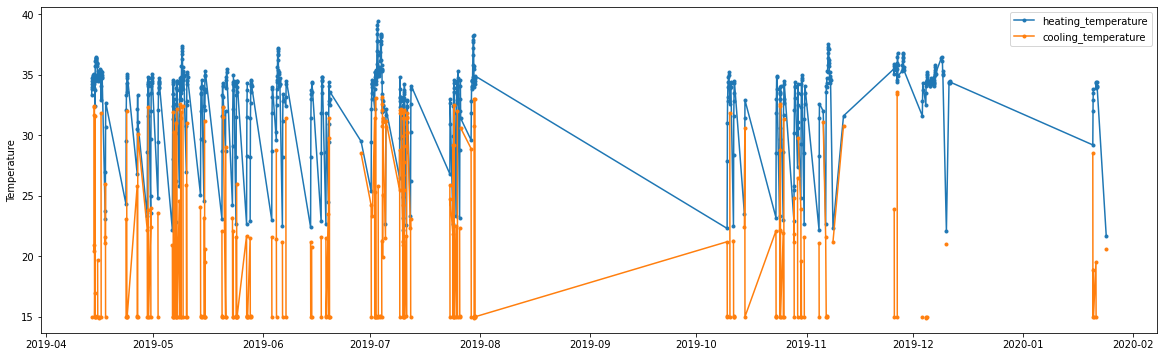

In [9]:
# plot the data
plt.figure(figsize = (20,6))
plt.plot(data_clean['heating_temperature'], label = 'heating_temperature',marker='o',markersize = 3)
plt.plot(data_clean['cooling_temperature'], label = 'cooling_temperature',marker='o',markersize=3)
plt.legend()
plt.ylabel('Temperature')
plt.show()

In [10]:
#add complementary data that will be useful later

#relative time in units of hours, relative to the first datapoint
data_clean = data_clean.assign(abstime = lambda x: (x.index - data_clean.index[0]).total_seconds() / 3600.) # in units of hours

In [11]:
display(data_clean)

,heating_temperature,cooling_temperature,abstime
datetime,,,
2019-04-13 17:51:16+00:00,33.3,15.0,0.000000
2019-04-13 18:51:18+00:00,34.0,NaN,1.000556
2019-04-13 19:51:20+00:00,33.8,NaN,2.001111
2019-04-13 20:51:21+00:00,34.2,NaN,3.001389
2019-04-13 21:51:23+00:00,34.5,NaN,4.001944
...,...,...,...
2020-01-21 14:28:40+00:00,34.3,NaN,6788.623333
2020-01-21 15:28:41+00:00,34.0,NaN,6789.623611
2020-01-21 16:28:43+00:00,34.1,NaN,6790.624167


# Exploratory Data Analysis

In [12]:
#number of proper measurements in each column
print("The are %d NaN's in 'heating_temperature' and %d actual numbers"  %((data_clean['heating_temperature'].isna()).sum(),(~data_clean['heating_temperature'].isna()).sum()))
print("The are %d NaN's in 'cooling_temperature' and %d actual numbers"  %((data_clean['cooling_temperature'].isna()).sum(),(~data_clean['cooling_temperature'].isna()).sum()))

The are 17 NaN's in 'heating_temperature' and 699 actual numbers
The are 415 NaN's in 'cooling_temperature' and 301 actual numbers


There are only 17 timestamps which contain only the cooling temperature, but 415 timestamps (more than half) which contain only the heating temperature. 

## Date/Time  
I analyze the times at which the measurements were recorded.

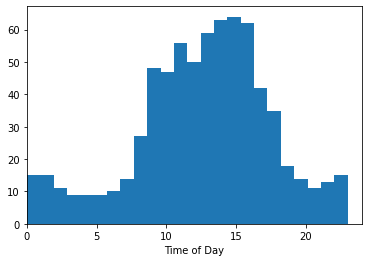

In [13]:
#plot the time of day at which the measurements were recorded
plt.figure()
plt.hist(data_clean.index.hour,bins= 24)
plt.xlim(0,24)
plt.xlabel('Time of Day')
plt.show()

It looks like, the majority of the measurements were recorded during 'office hours' (8:00 - 18:00). However, some of the measurements were also recorded at nighttime. 

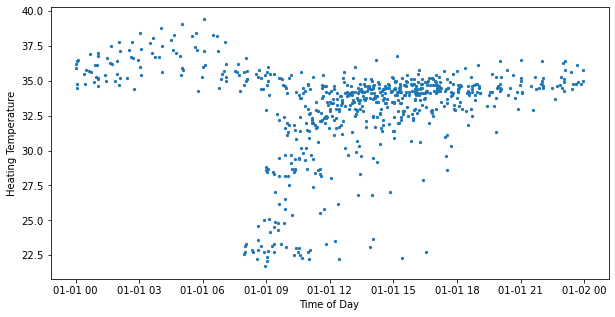

In [14]:
# Plot the distribution of 'heating_temperature' recordings vs time of day
data_clean['time_of_day'] = data_clean.index.map(lambda x: x.replace(day=1,month = 1, year = 2023)) #make a new column an set the date to 2023-01-01 to simplify the comparison

plt.figure(figsize = (10,5))
plt.scatter(data_clean['time_of_day'],data_clean['heating_temperature'],s = 5)
plt.xlabel('Time of Day')
plt.ylabel('Heating Temperature')
plt.show()

The above plot shows that the 'heating_temperature' recordings are somewhat correlated on a 24h interval. However, they are not perfectly correlated. The low-temperature measurements (< 30 degrees) are more concentrated towards the mornings (at around 9:00-ish), but there are also some in the afternoon (until 18:00). The majority of the measurements cluster around a temperature of 34 degrees and between 10:00 and 18:00. \
There exists no analogous correlation in the 'cooling_temperature' data. 

Motivated by the observation above, I add another time axis to the DataFrame in which I remove every 24h period that does not contain a data point.

In [15]:
# I remove every calendar day from 'abstime' in which no data was recorded and save it in 'abstime_continious'
data_clean['abstime_continious'] = data_clean['abstime']

reduction = 0 #to keep track of the number of days I have removed
for i in range(len(data_clean.index) - 1): #loop over the rows
    rel_time = (data_clean['abstime'].iloc[i+1] - data_clean['abstime'].iloc[i]) # relative time between consecutive measurements in units of hours
    reduction += rel_time // 24. #increment by one if the increment between consecutive measurements is larger than 24 hours
    data_clean.loc[data_clean.index[i+1], 'abstime_continious'] = data_clean['abstime'].iloc[i+1] - reduction * 24.

    

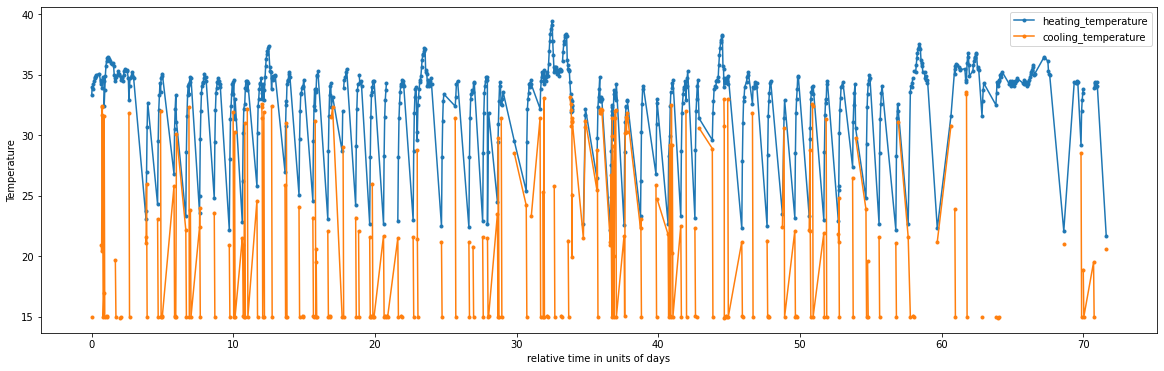

In [16]:
# plot the data with 'abstime_continious' along the x-axis (the plot looks much nicer)
plt.figure(figsize = (20,6))
plt.plot(data_clean['abstime_continious'] / 24, data_clean['heating_temperature'], label = 'heating_temperature',marker='o',markersize = 3)
plt.plot(data_clean['abstime_continious'] / 24, data_clean['cooling_temperature'], label = 'cooling_temperature',marker='o',markersize=3)
plt.legend()
plt.ylabel('Temperature')
plt.xlabel('relative time in units of days')
plt.show()

I will look at time intervals between measurements next. 

In [17]:
data_clean['dt'] = data_clean['abstime_continious'].diff() #time interval between individual measurements

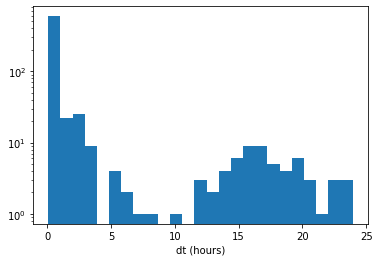

In [18]:
# plot the distribution of the time intervals 'dt'
plt.figure()
plt.hist(data_clean['dt'],bins= 25)
plt.xlabel('dt (hours)')
plt.yscale('log')
plt.show()

The sampling of the data is very nonuniform. \
The distribution of the time intervals is bimodal, with the highest peak of the entire distribution at around 1 hour. I think the left-hand side part of the distribution comes from continuous operation of data recording, while the right hand side part comes from the fact that measurement recording is sometimes interrupted, e.g. during the night or for even longer periods. 

## Temperature Correlations
Next, I look at distributions and correlations between the temperature measurements. 

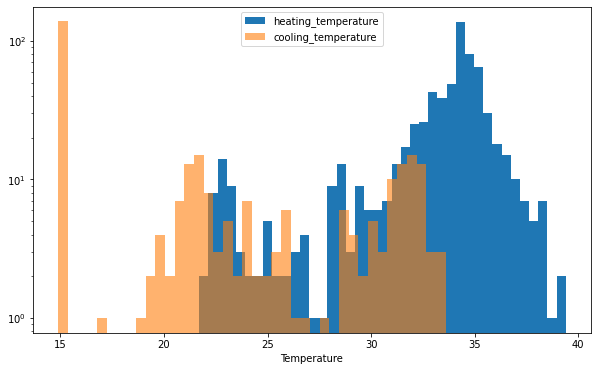

In [19]:
#plot the histogram of temperature measurements
plt.figure(figsize = (10,6))
plt.hist(data_clean['heating_temperature'], bins= 40,label='heating_temperature')
plt.hist(data_clean['cooling_temperature'], bins = 40, alpha = 0.6,label='cooling_temperature')
plt.yscale('log')
plt.xlabel('Temperature')
plt.legend()
plt.show()

There are many 'cooling_temperature' measurements that recorded a value of 15 degrees. \
Above 15 degrees, both 'cooling_temperature' and 'heating_temperature' show a bimodal distribution, but the 'cooling_temperature' seems shifted towards lower temperatures by about two degrees. \
I study the correlation of individual measurements next. 

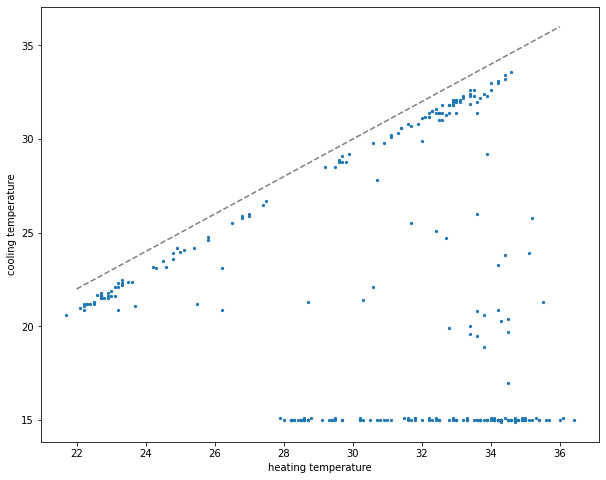

In [20]:
#plot corrleation between 'heating_temperature' and 'cooling_temperature'
plt.figure(figsize = (10,8))
plt.scatter(data_clean['heating_temperature'],data_clean['cooling_temperature'], s = 5)
plt.plot([22,36], [22,36] ,color='grey',linestyle = '--') # add a 1:1 correlation line for comparison (slope 1)
plt.xlabel('heating temperature')
plt.ylabel('cooling temperature')
plt.show()

There are three distinct populations in the above correlation plot. The first population shows a linear correlation with slope 1 (see dashed line for comparison). The second population is located at a constant cooling temperature of 15 degrees. The third population is scattered in between the two first populations, with no apparent structure.  

## Data Analysis Conclusions

In the dataset, I have found time series data with recordings of 'heating_temperature' and 'cooling_temperature'. I assume this data comes from a device that requires some sort of active temperature control via cooling and heating. \
The data has gaps in which no data was recorded. Some gaps are very large (up to several weeks), some gaps are small (a few hours). I noticed that if the gap is larger than a few hours, the heating temperature drops to a level below 30 degrees (I assume the units are degrees) on the subsequent measurement. When data recording starts again, the temperature climbs to about 35 degrees again. In places where there is data, the dominant sampling rate seems to be one hour. But there are many data points which are separated by less than one hour or more than one hour. \
Data recording happened predominantly between 09:00 and 18:00, i.e. during 'office hours'. There are also some data recordings during the night, but much less frequent. \
\
Due to the discontinuous nature of the temperature data, and the non-uniformity of the time steps, I avoid resampling the data. Unfortunately, this makes it harder to deal with the data, but I think I would add unwanted artifacts by resampling. \
Comparing 'heating_temperature' and 'cooling_temperature', I noticed there are 415 points in time when a heating temperature was recorded but no cooling temperature. On the other hand, there are only 17 points in time in which only a cooling temperature was recorded. In total, there are 301 instances (out of 716) where both temperatures were recorded. These 301 x 2 data points show an interesting correlation, and I divided them into three distinct populations. \
\
Without knowing where the data came from and how it was recorded, it is difficult to decide on which features to focus. Therefore, for the remainder of this project, I am going to assume that the device in question records data only when it is in operation. When the device is switched off, it does not record data and therefore large temporal gaps can appear in the data. When the device is not in operation, I assume the 'heating temperature' decreases and whenever the device is switched back on, the temperature increases to an 'operation window' between about 30 to 40 degrees. Furthermore, I assume that the device is switched on by a human and not by an electronically controlled schedule. This then would explain some of the temporal irregularity of the 'heating_temperature' data. 

# Project Formulation

Based on the above analysis, I assume the device that records the data is operated by a human and therefore the irregular gaps in the data are introduced by an operator. Consequently, the gaps in the time series are not relevant for anomaly detection. Thus, in this project, I aim to find anomalies solely in the temperature recordings of both the 'heating_temperature' and 'cooling_temperature'. I especially focus on large temperature which could be harmful for the device. 

## Heating Temperature
I first focus on the heating temperature data. As mentioned above, there are 17 'missing' data points for this temperature in the recordings. This number is small compared to the overall number of data points. I might be able to recover these missing values by interpolation. 

### Missing Datapoints

In [21]:
#print the indices of missing 'heating_temperature' values
index_list = np.arange((716))
map = data_clean['heating_temperature'].isna().to_numpy()# map to all the NaN's in 'heating_temperature'
print(index_list[map]) #print the list to have a look at it

[ 15  16  42 206 217 238 239 339 371 394 433 451 495 594 595 707 708]


In [22]:
#interpolation with panda built-in interpolator using the 'time' method
data_clean['heating_temperature'] = data_clean['heating_temperature'].interpolate(method='time')

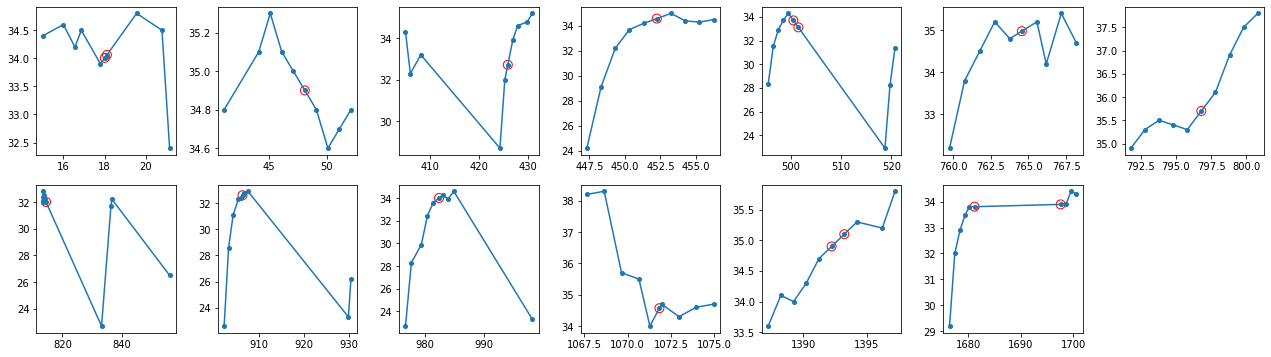

In [23]:
#inspect the interpolated values to see if it worked properly. 

#I copy the NaN indices to a list and nest consecutive indices
NaN_list = [[15,  16], [42], [206], [217], [238, 239], [339], [371], [394], [433], [451], [495], [594, 595], [707, 708]] #fastest to write it out by hand

# There are 13 locations with NaN's -> I make a 2x7 plot. 
Nrows = 2
Ncols = 7

fig, ax  = plt.subplots(nrows=Nrows, ncols=Ncols,sharex=False,sharey=False,figsize=(22,6),gridspec_kw={'hspace': 0.2, 'wspace': 0.3})
for i in range(Nrows):
    for j in range(Ncols):
        k = j+i*Ncols
        if ( k < 13):
        #k = 5
            ix_grid = np.arange(NaN_list[k][0]-5,NaN_list[k][0]+5) #I include 5 datapoints before the NaN and 5 after. 
            ax[i,j].plot(data_clean['abstime_continious'][ix_grid], data_clean['heating_temperature'][ix_grid],marker = 'o',markersize = 4) #plot the heating temperature
            ax[i,j].scatter(data_clean['abstime_continious'][NaN_list[k]],data_clean['heating_temperature'][NaN_list[k]],s=80, facecolors='none', edgecolor = 'r') #mark the interpolated values with a red circle

ax[1,6].axis('off')
plt.show()

I marked the interpolated data points with red circles. The interpolation could be better, but I am satisfied with the result. 

To find heating temperature anomalies that are potentially harmful for the device, I look at temperature peaks in the data. 

In [24]:
peaks, _ = find_peaks(data_clean['heating_temperature']) #find peaks in the heating_temperature data using scipy's 'find_peaks'

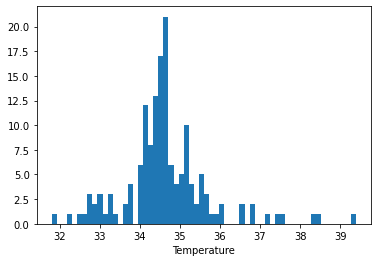

In [25]:
#plot the distribution of the heating temperature peaks
plt.figure()
plt.hist(data_clean['heating_temperature'][peaks],bins = 60)
plt.xlabel('Temperature')
plt.show()

The heating temperature peaks seem to be concentrated most between 34 and 35 degrees. There are a few outliers beyond 36 degrees. I want to classify them as anomalies. For this, I assume the peaks are normally distributed. Then I can model the distribution with a Gaussian. 

In [26]:
#fit a Gaussian to find the underlying distribution of the heating temperature peaks
gm_model = GaussianMixture(n_components=1).fit(data_clean['heating_temperature'][peaks].to_numpy()[:,np.newaxis]) #use sklearn's GaussianMixture with one component

mu = gm_model.means_[0,0] #mean 
sigma = np.sqrt(gm_model.covariances_[0][0][0]) #standard deviation
heating_thre = sigma + mu #hating threshold

I assume anomalous temperatures lie beyond one standard deviation away from the mean. I set the heating temperature threshold to this value. 

In [27]:
print("The heating temperature threshold lies at: %.2f degrees" %heating_thre)

The heating temperature threshold lies at: 35.72 degrees


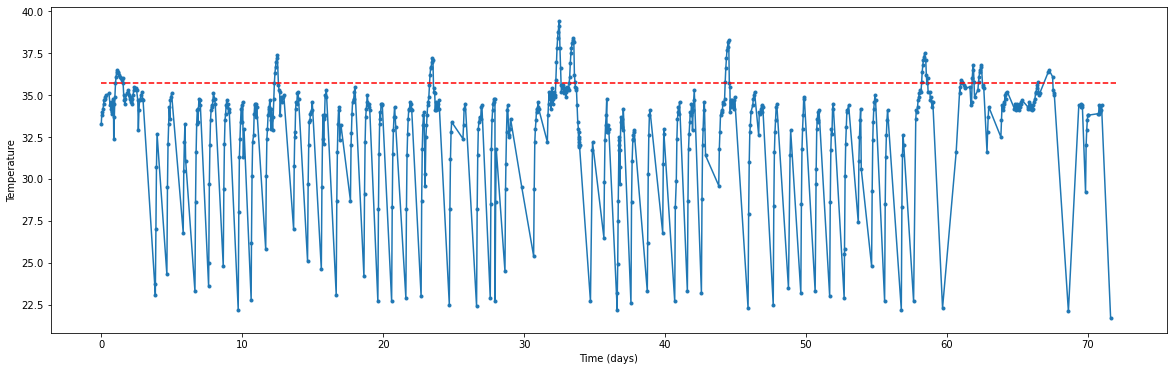

In [28]:
#plot the heating temperature threshold in red color
plt.figure(figsize=(20,6))
plt.plot(data_clean['abstime_continious'] / 24,data_clean['heating_temperature'],marker = 'o', markersize = '3')
plt.plot([0,72],[heating_thre,heating_thre],linestyle = '--', color = 'r')
plt.xlabel('Time (days)')
plt.ylabel('Temperature')
plt.show()

## Cooling Temperature
I now focus on the cooling temperature measurements. \
After the interpolation of the heating temperature, there are no more NaN's in 'heating temperature'. Thus, every cooling temperature measurement now has a corresponding heating temperature measurement. I perform some more analysis to find out more about the cooling temperature. \
First, I use the DBSCAN clustering algorithm to cluster the cooling temperature data based on their correlation to the heating temperature.

In [29]:
correlation_data = np.array(list(zip(data_clean['heating_temperature'][~data_clean['cooling_temperature'].isna()], data_clean['cooling_temperature'][~data_clean['cooling_temperature'].isna()])))
db_clustering = DBSCAN(eps=1.0, min_samples=5).fit_predict(correlation_data) #perform DBSCAN clustering on the correlation data. I use empirical hyperparameters that best seperate the three populations that I described earlier

In [30]:
#DBSCAN was not perfect so I merge cluster -1 with 1 and cluster 3 with 2
db_clustering[db_clustering == -1] = 1
db_clustering[db_clustering == 3] = 2

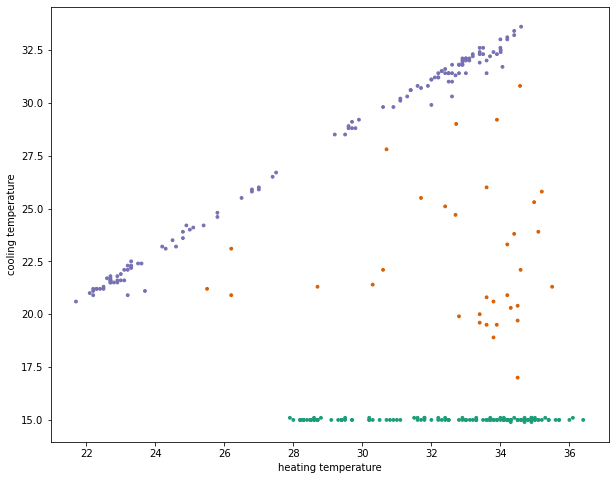

In [31]:
#plot the result corrleation data and colr the datapoints based on the three clusters
cmap = "Dark2"
colors = plt.get_cmap(cmap)

plt.figure(figsize = (10,8))
plt.scatter(correlation_data[:,0],correlation_data[:,1], s = 8,color = colors(db_clustering))
plt.xlabel('heating temperature')
plt.ylabel('cooling temperature')
plt.show()

The three populations are nicely separated. 

In [32]:
print("The green population (cluster 0) contains %d datapoints." %(len(db_clustering[db_clustering == 0])))
print("The red population (cluster 1) contains %d datapoints." %(len(db_clustering[db_clustering == 1])))
print("The purple population (cluster 2) contains %d datapoints." %(len(db_clustering[db_clustering == 2])))

The green population (cluster 0) contains 138 datapoints.
The red population (cluster 1) contains 34 datapoints.
The purple population (cluster 2) contains 129 datapoints.


Out of curiosity, I study the correlations of the cooling temperature in different clusters with the time interval 'dt'.

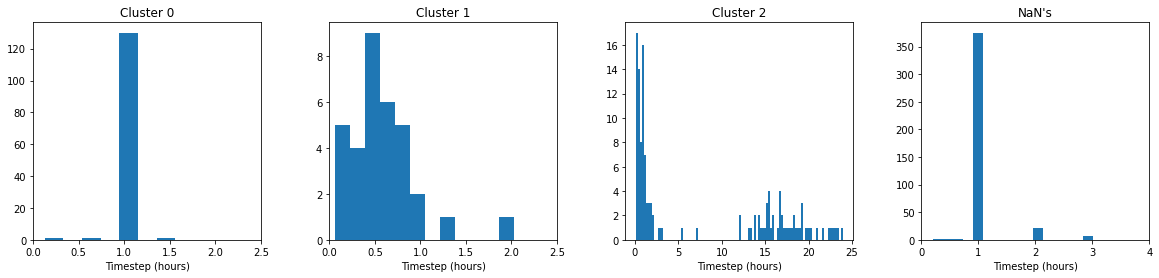

In [33]:
Ncols = 4

fig, ax  = plt.subplots(nrows=1, ncols=Ncols,sharex=False,sharey=False,figsize=(20,4),gridspec_kw={'hspace': 0.2, 'wspace': 0.3})
for i in range(Ncols-1): #loop over 3 clusters
    ax[i].hist(data_clean['dt'][~data_clean['cooling_temperature'].isna()][db_clustering==i],bins = 100) #histogram of cooling temperature of cluster i
    ax[i].set_title('Cluster %d'%i)
    ax[i].set_xlabel('Timestep (hours)')

ax[3].hist(data_clean['dt'][data_clean['cooling_temperature'].isna()],bins = 100) #also plot the 'dt' histogram for the entries containing NaN's
ax[3].set_xlabel('Timestep (hours)')
ax[3].set_title("NaN's")

ax[0].set_xlim(0.0,2.5)
ax[1].set_xlim(0.0,2.5)
ax[3].set_xlim(0.0,4)
plt.show()


Interestingly, I find that almost all the data points that belong to the green cluster (cluster 0) and also almost all the NaN values in 'cooling_temperature' are recorded after time steps of exactly one hour. Some NaN's also appear if their timestep is a multiple of one (2,3).\
The majority of the data points that belong to the red cluster (cluster 1) are recorded after time steps that are smaller than one hour. 
\
Following a timestep that is larger than 10 hours, the 'cooling_temperature' data point almost exclusively belongs to the purple cluster (cluster 2). 

In [34]:
#Display some arbitrary data of 'cooling_temperature' and 'dt'
display(data_clean[['cooling_temperature','dt']][50:80])

,cooling_temperature,dt
datetime,,
2019-04-16 01:57:38+00:00,NaN,1.000556
2019-04-16 04:57:43+00:00,NaN,3.001389
2019-04-16 05:57:44+00:00,NaN,1.000278
2019-04-16 07:57:48+00:00,NaN,2.001111
2019-04-16 08:58:39+00:00,31.8,1.014167
2019-04-16 09:58:40+00:00,15.0,1.000278
2019-04-16 10:58:42+00:00,NaN,1.000556
2019-04-16 13:58:47+00:00,NaN,3.001389
2019-04-16 14:58:49+00:00,NaN,1.000556


Looking at the data above, I realized that 'cooling_temperature' is neither 15 degrees nor NaN only if the timestep is neither equal to an hour nor an exact multiple of an hour. \
I speculate that such a timestep must cause erroneous behavior in the device. I thus conclude that a cooling temperature reading of 15 degrees (\pm 0.1) should not be trusted. \
I am thus left with only 163 proper readings of the cooling temperature in comparison with 553 missing or erroneous values. \
Because the number of proper readings is much smaller than the number of missing/erroneous values, I do not continue to analyze them statistically. But, I can use the cooling-heating correlation and the labels that I have generated to build a classifier for the cooling temperature data (although, I wish the sample size would be larger for this task too). 

## Classifier
Since the decision boundaries appear pretty linear in the correlation plot, I use a simple logistic regression classifier. 

In [35]:
#train/test split 0.7/0.3
X_train, X_test, y_train, y_test = train_test_split(correlation_data,db_clustering, test_size=0.3, random_state=42)

In [36]:
clf = LogisticRegression() #sklearn classifier, I use the default parameters
clf.fit(X_train, y_train) #fit the training data

LogisticRegression()

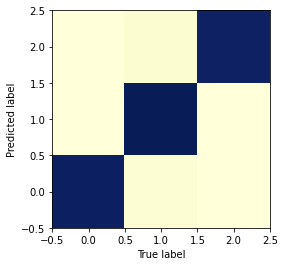

In [37]:
#create a confusion matrix
y_predicted_label = clf.predict(X_train) #predict labels from the trainig set
y_test_predicted_label = clf.predict(X_test) #predict labels from the testing set
cm = confusion_matrix(y_test, y_test_predicted_label) #construct confusion matrix

#plot the (normalized) confusion matrix
plt.figure()
plt.imshow((cm / cm.sum(axis=0)).T, cmap='YlGnBu', origin='lower')
plt.xlabel('True label')
plt.ylabel('Predicted label')
plt.show()

looks good to me.

# Anomaly Detector
I now build the anomaly detectors that detects heating temperature anomalies and also classifies the cooling temperature data. For the latter, I consider class 0 and class 1 to be anomalous. 

In [38]:
def anomaly_detector(DataFrameX):
    #####################################
    #INPUT:
    #Pandas DataFrame with columns 'cooling_temperature' and 'heating_temperature'
    #'heating_temperature' must not contain NaN's
    #
    #OUTPUT:
    #i_cooling_data: list that contains the indices of all the cooling data, i.e. where it is not NaN
    #label_cooling_data: list that contains labels for for the cooling data at indices in i_cooling_data
    #i_heating_data: list that contains the indices of anomalous heating  data
    #####################################

    index_list = np.arange(len(DataFrameX.index)) #array that contains all the DataFrame indices

    #####################################
    #heatimg temperature anomaly
    heating_temp_limit = heating_thre #heating threshhold above which I consider the temperature to be anomalous
    i_heating_data = index_list[DataFrameX['heating_temperature'] > heating_temp_limit] #list that contains the indices of anomalous heating  data

    #####################################
    #cooling temperature anomaly
    X_corr_data = np.array(list(zip(DataFrameX['heating_temperature'][~DataFrameX['cooling_temperature'].isna()], DataFrameX['cooling_temperature'][~DataFrameX['cooling_temperature'].isna()]))) #correlation data for the classifier
    i_cooling_data = index_list[~DataFrameX['cooling_temperature'].isna()] #list that contains the indices of all the cooling data, i.e. where it is not NaN
    label_cooling_data = clf.predict(X_corr_data) #list that contains labels for for the cooling data at indices in i_cooling_data

    return i_cooling_data, label_cooling_data, i_heating_data

In [39]:
#run the anomaly detector
i_cooling_data, label_cooling_data, i_heating_data = anomaly_detector(data_clean)

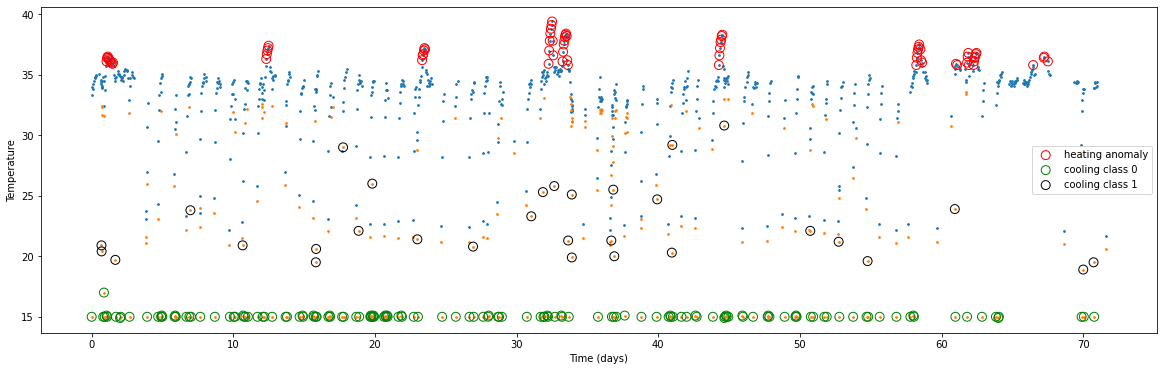

In [40]:
#plot
plt.figure(figsize=(20,6))
#plot the data
plt.scatter(data_clean['abstime_continious'] / 24,data_clean['heating_temperature'],s=3)
plt.scatter(data_clean['abstime_continious'] / 24,data_clean['cooling_temperature'],s=3)
#heating anomaly
plt.scatter(data_clean['abstime_continious'][i_heating_data] / 24, data_clean['heating_temperature'][i_heating_data],s=80, facecolors='none', edgecolor = 'r', label = 'heating anomaly')
#cooling class 0 and 1
plt.scatter(data_clean['abstime_continious'][i_cooling_data][label_cooling_data == 0] / 24  ,data_clean['cooling_temperature'][i_cooling_data][label_cooling_data == 0],s=80, facecolors='none', edgecolor = 'g',label = 'cooling class 0')
plt.scatter(data_clean['abstime_continious'][i_cooling_data][label_cooling_data == 1] / 24  ,data_clean['cooling_temperature'][i_cooling_data][label_cooling_data == 1],s=80, facecolors='none', edgecolor = 'k',label = 'cooling class 1')

plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Temperature')
plt.show()

## Testing
As a final step, I introduce artificial data to test whether the anomaly detector also works on new data. 

In [41]:
#add artifical data at arbitrary location to test the anomaly detector
data_test = data_clean.copy()
data_test.loc[data_test.index[300], 'heating_temperature'] = 40 #large heating time 
data_test.loc[data_test.index[300], 'cooling_temperature'] = 26 #cooling time that is significantly lower than the heating time

In [42]:
#run the anomaly detector
i_cooling_data, label_cooling_data, i_heating_data = anomaly_detector(data_test)

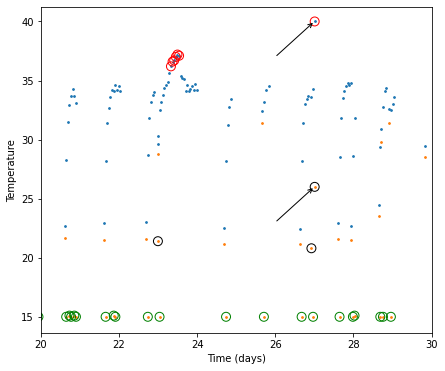

In [43]:
plt.figure(figsize=(7,6))
#plot the data
plt.scatter(data_test['abstime_continious'] / 24,data_test['heating_temperature'],s=3)
plt.scatter(data_test['abstime_continious'] / 24,data_test['cooling_temperature'],s=3)
#heating anomaly
plt.scatter(data_test['abstime_continious'][i_heating_data] / 24, data_test['heating_temperature'][i_heating_data],s=80, facecolors='none', edgecolor = 'r', label = 'heating anomaly')
#cooling class 0 and 1
plt.scatter(data_test['abstime_continious'][i_cooling_data][label_cooling_data == 0] / 24  ,data_test['cooling_temperature'][i_cooling_data][label_cooling_data == 0],s=80, facecolors='none', edgecolor = 'g',label = 'cooling class 0')
plt.scatter(data_test['abstime_continious'][i_cooling_data][label_cooling_data == 1] / 24  ,data_test['cooling_temperature'][i_cooling_data][label_cooling_data == 1],s=80, facecolors='none', edgecolor = 'k',label = 'cooling class 1')

#plt.legend()
plt.xlabel('Time (days)')
plt.ylabel('Temperature')
plt.annotate("", xy=(27., 40.), xytext=(26, 37),arrowprops=dict(arrowstyle="->"))
plt.annotate("", xy=(27., 26.), xytext=(26, 23),arrowprops=dict(arrowstyle="->"))
plt.xlim(20,30)
plt.show()

I have highlighted the artificial data points with arrows. Both of them are successfully captured by the anomaly detector. 